In [2]:
!pip install pennylane scikit-learn matplotlib

  Using cached pennylane-0.43.0-py3-none-any.whl.metadata (11 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 107.0 MB/s eta 0:00:00


In [3]:
# --- STEP 1: Mount Drive ---
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Computing quantum kernel matrices (may take ~2–3 mins for small data)...

=== Quantum SVM Results ===
Accuracy: 0.647
Confusion Matrix:
 [[13  6]
 [ 6  9]]

=== Classical RBF SVM Results ===
Accuracy: 0.765
Confusion Matrix:
 [[15  4]
 [ 4 11]]


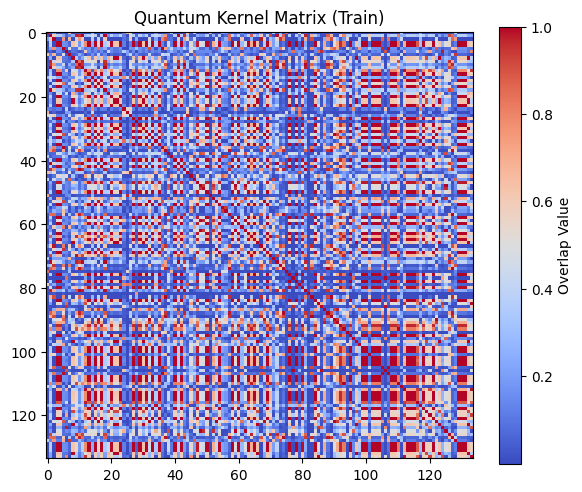

In [10]:
# --- Imports ---
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# --- Load dataset ---
df = pd.read_csv("/content/drive/MyDrive/datasets/final_dryness_proxy_all.csv")

feat_cols = ["nectar_ml", "sugar_perc", "corolla_mm"]
target_col = "time_to_dry_days"

# --- Convert to binary classification (dry vs. not dry) ---
y = (df[target_col] > 3.5).astype(int).values
X = df[feat_cols].values

# --- Train/test split and scaling ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# --- Quantum device ---
n_qubits = len(feat_cols)
dev = qml.device("default.qubit", wires=n_qubits)

# --- Quantum feature map (angle embedding + CZ entanglement) ---
def feature_map(x):
    for i in range(n_qubits):
        qml.RY(np.pi * x[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i + 1])

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    return qml.probs(wires=range(n_qubits))

def quantum_kernel_matrix(X1, X2):
    """Compute quantum kernel matrix."""
    n1, n2 = len(X1), len(X2)
    kernel = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            probs = kernel_circuit(X1[i], X2[j])
            kernel[i, j] = probs[0]  # overlap probability of |000...0>
    return kernel

# --- Kernel computation ---
print("Computing quantum kernel matrices (may take ~2–3 mins for small data)...")
K_train = quantum_kernel_matrix(X_train, X_train)
K_test = quantum_kernel_matrix(X_test, X_train)

# --- QSVM training ---
qsvm = SVC(kernel="precomputed")
qsvm.fit(K_train, y_train)
y_pred_q = qsvm.predict(K_test)

# --- Classical SVM for comparison ---
rbf_svm = SVC(kernel="rbf", gamma='scale')
rbf_svm.fit(X_train, y_train)
y_pred_c = rbf_svm.predict(X_test)

# --- Evaluation ---
print("\n=== Quantum SVM Results ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_q), 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_q))

print("\n=== Classical RBF SVM Results ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_c), 3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_c))

# --- Visualization ---
plt.figure(figsize=(6, 5))
plt.imshow(K_train, cmap="coolwarm")
plt.title("Quantum Kernel Matrix (Train)")
plt.colorbar(label="Overlap Value")
plt.tight_layout()
plt.show()

Computing quantum kernel matrices (this may take a few minutes)...

=== Quantum Kernel Regressor (QKR) ===
MAE: 2.361
R² : -0.0

=== Classical RBF SVR ===
MAE: 1.928
R² : 0.272


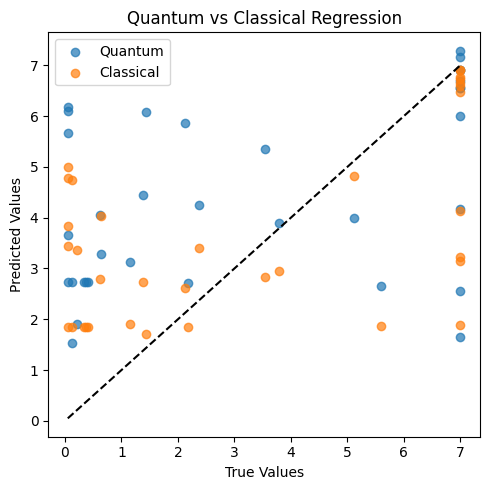

In [12]:
# --- Imports ---
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# --- Load dataset ---
df = pd.read_csv("/content/drive/MyDrive/datasets/final_dryness_proxy_all.csv")

feat_cols = ["nectar_ml", "sugar_perc", "corolla_mm"]
target_col = "time_to_dry_days"

X = df[feat_cols].values
y = df[target_col].values

# --- Train/test split & scaling ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# --- Quantum device ---
n_qubits = len(feat_cols)
dev = qml.device("default.qubit", wires=n_qubits)

# --- Quantum feature map ---
def feature_map(x):
    for i in range(n_qubits):
        qml.RY(np.pi * x[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i + 1])

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    return qml.probs(wires=range(n_qubits))

def quantum_kernel_matrix(X1, X2):
    """Compute quantum kernel matrix via state overlap."""
    n1, n2 = len(X1), len(X2)
    kernel = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            probs = kernel_circuit(X1[i], X2[j])
            kernel[i, j] = probs[0]
    return kernel

# --- Compute kernels ---
print("Computing quantum kernel matrices (this may take a few minutes)...")
K_train = quantum_kernel_matrix(X_train, X_train)
K_test = quantum_kernel_matrix(X_test, X_train)

# --- Quantum Kernel Regressor (SVR) ---
qkr = SVR(kernel="precomputed", C=1.0, epsilon=0.1)
qkr.fit(K_train, y_train)
y_pred_qkr = qkr.predict(K_test)

# --- Classical baseline (RBF SVR) ---
from sklearn.svm import SVR
rsvr = SVR(kernel="rbf")
rsvr.fit(X_train, y_train)
y_pred_classical = rsvr.predict(X_test)

# --- Evaluation ---
print("\n=== Quantum Kernel Regressor (QKR) ===")
print("MAE:", round(mean_absolute_error(y_test, y_pred_qkr), 3))
print("R² :", round(r2_score(y_test, y_pred_qkr), 3))

print("\n=== Classical RBF SVR ===")
print("MAE:", round(mean_absolute_error(y_test, y_pred_classical), 3))
print("R² :", round(r2_score(y_test, y_pred_classical), 3))

# --- Visualization ---
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_qkr, label="Quantum", alpha=0.7)
plt.scatter(y_test, y_pred_classical, label="Classical", alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Quantum vs Classical Regression")
plt.legend()
plt.tight_layout()
plt.show()

Numeric columns used for PCA: ['flowering_start', 'flowering_end', 'flowering_times', 'flowers_m2', 'nectar_ml', 'sugar_concentration_mol', 'sugar_concentration_perc', 'nectar_sugar_content_mg', 'pollen_mg', 'corolla_mm', 'protein', 'sugar_perc', 'time_to_dry_proxy_raw', 'time_to_dry_days', 'gmm_confidence', 'gmm_label']
Explained variance ratio (3 components): [0.18882893 0.15053974 0.11634692], total=0.456
Computing kernel matrices...
QSVM Accuracy (PCA->3): 0.38235294117647056
QSVM Confusion Matrix:
 [[ 7 12]
 [ 9  6]]
QKR MAE (PCA->3): 3.1275926074309535
QKR R2 (PCA->3): -0.4740861530687783
Classical RBF SVM Accuracy (PCA->3): 0.7058823529411765
Classical SVR MAE (PCA->3): 2.13205255204887
Classical SVR R2 (PCA->3): 0.13517685503378996


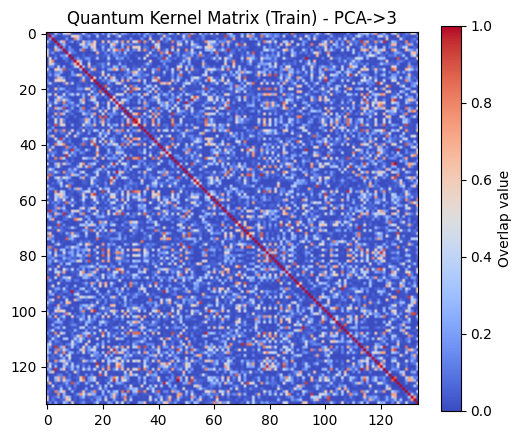

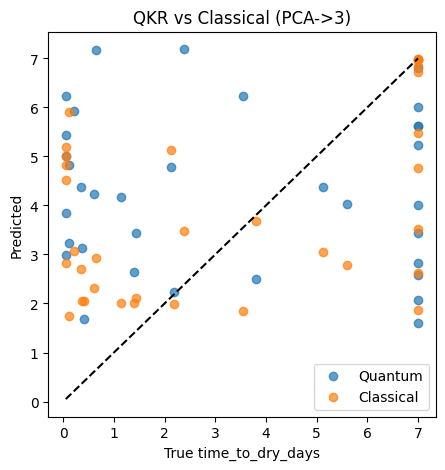

In [14]:
# === PCA + Quantum pipeline (QSVM and QKR) ===
import numpy as np
import pandas as pd
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ---- Config ----
DATA_PATH = "/content/drive/MyDrive/datasets/final_dryness_proxy_all.csv"  # change as needed
NUM_PCA_COMPONENTS = 3
RANDOM_STATE = 42

# ---- Load dataset ----
df = pd.read_csv(DATA_PATH)

# ---- Choose numeric columns (auto-detect) ----
num_df = df.select_dtypes(include=[np.number]).copy()
print("Numeric columns used for PCA:", num_df.columns.tolist())

# ---- Optional: drop the target if it's present in numeric set ----
target_col = "time_to_dry_days"
if target_col in num_df.columns:
    num_df = num_df.drop(columns=[target_col])

# ---- Fill missing numeric values (simple mean imputation) ----
num_df = num_df.fillna(num_df.mean())

# ---- Standardize before PCA ----
scaler_full = StandardScaler().fit(num_df.values)
X_num_std = scaler_full.transform(num_df.values)

# ---- PCA to 3 components ----
pca = PCA(n_components=NUM_PCA_COMPONENTS, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_num_std)
explained = pca.explained_variance_ratio_
print(f"Explained variance ratio (3 components): {explained}, total={explained.sum():.3f}")

# ---- Prepare targets ----
y_reg = df[target_col].values  # continuous target for regression
# binary label (optional) for QSVM classification (choose threshold)
threshold_days = 3.5
y_cls = (y_reg > threshold_days).astype(int)

# ---- Train/test split (use continuous target split; for classification you can use y_cls) ----
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X_pca, y_reg, test_size=0.2, random_state=RANDOM_STATE
)
# For classification: split matching indices
_, _, y_train_cls, y_test_cls = train_test_split(
    X_pca, y_cls, test_size=0.2, random_state=RANDOM_STATE
)

# ---- Quantum device and feature map (3 qubits) ----
n_qubits = NUM_PCA_COMPONENTS
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x):
    # Angle embedding of PCA components + simple nearest-neighbor CZ entanglement
    for i in range(n_qubits):
        qml.RY(np.pi * float(x[i]), wires=i)
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    return qml.probs(wires=range(n_qubits))

def quantum_kernel_matrix(X1, X2):
    n1, n2 = len(X1), len(X2)
    K = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            probs = kernel_circuit(X1[i], X2[j])
            K[i, j] = float(probs[0])  # overlap on |00..0>
    return K

# --- Compute kernel matrices (fast for small datasets) ---
print("Computing kernel matrices...")
K_train = quantum_kernel_matrix(X_train, X_train)
K_test = quantum_kernel_matrix(X_test, X_train)

# === 1) QSVM (classification on PCA components) ===
qsvm = SVC(kernel="precomputed")
qsvm.fit(K_train, y_train_cls)
y_pred_q_cls = qsvm.predict(K_test)
print("QSVM Accuracy (PCA->3):", accuracy_score(y_test_cls, y_pred_q_cls))
print("QSVM Confusion Matrix:\n", confusion_matrix(y_test_cls, y_pred_q_cls))

# === 2) QKR (regression using SVR on quantum kernel) ===
qkr = SVR(kernel="precomputed", C=1.0, epsilon=0.1)
qkr.fit(K_train, y_train_reg)
y_pred_q_reg = qkr.predict(K_test)
print("QKR MAE (PCA->3):", mean_absolute_error(y_test_reg, y_pred_q_reg))
print("QKR R2 (PCA->3):", r2_score(y_test_reg, y_pred_q_reg))

# === Classical baselines (using PCA components directly) ===
# Classical SVM classifier (RBF on PCA)
clf_rbf = SVC(kernel="rbf", gamma="scale")
clf_rbf.fit(X_train, y_train_cls)
y_pred_c_cls = clf_rbf.predict(X_test)
print("Classical RBF SVM Accuracy (PCA->3):", accuracy_score(y_test_cls, y_pred_c_cls))

# Classical SVR (RBF) on PCA
rsvr = SVR(kernel="rbf")
rsvr.fit(X_train, y_train_reg)
y_pred_c_reg = rsvr.predict(X_test)
print("Classical SVR MAE (PCA->3):", mean_absolute_error(y_test_reg, y_pred_c_reg))
print("Classical SVR R2 (PCA->3):", r2_score(y_test_reg, y_pred_c_reg))

# === Visualizations ===
plt.figure(figsize=(6,5))
plt.imshow(K_train, cmap="coolwarm")
plt.title("Quantum Kernel Matrix (Train) - PCA->3")
plt.colorbar(label="Overlap value")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(y_test_reg, y_pred_q_reg, label="Quantum", alpha=0.7)
plt.scatter(y_test_reg, y_pred_c_reg, label="Classical", alpha=0.7)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel("True time_to_dry_days")
plt.ylabel("Predicted")
plt.legend()
plt.title("QKR vs Classical (PCA->3)")
plt.show()

Explained variance ratio (3 components): [0.18882893 0.15053974 0.11634692], total=0.456

=== Classical SVR (RBF) ===
MAE: 2.13205255204887
R² : 0.13517685503378996

=== Classical Linear Regression ===
MAE: 2.089235922246102
R² : 0.3486224554263804

=== Classical SVM (RBF) ===
Accuracy: 0.7058823529411765
Confusion Matrix:
 [[14  5]
 [ 5 10]]

=== Classical Logistic Regression ===
Accuracy: 0.7647058823529411
Confusion Matrix:
 [[16  3]
 [ 5 10]]


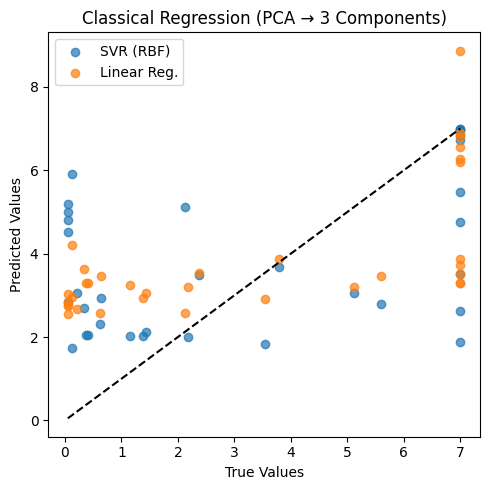

In [15]:
# === Classical ML Regression and Classification (PCA → 3 components) ===
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_absolute_error,
    r2_score,
)
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("/content/drive/MyDrive/datasets/final_dryness_proxy_all.csv")

# --- Select numeric features ---
num_df = df.select_dtypes(include=[np.number]).copy()
target_col = "time_to_dry_days"
if target_col in num_df.columns:
    num_df = num_df.drop(columns=[target_col])
num_df = num_df.fillna(num_df.mean())

# --- Standardize numeric features ---
scaler = StandardScaler().fit(num_df)
X_std = scaler.transform(num_df)

# --- PCA to 3 components ---
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_std)
explained = pca.explained_variance_ratio_
print(f"Explained variance ratio (3 components): {explained}, total={explained.sum():.3f}")

# --- Prepare targets ---
y_reg = df[target_col].values
y_cls = (y_reg > 3.5).astype(int)

# --- Split data ---
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X_pca, y_reg, test_size=0.2, random_state=42
)
_, _, y_train_cls, y_test_cls = train_test_split(
    X_pca, y_cls, test_size=0.2, random_state=42
)

# === Classical Regression (SVR + Linear Regression) ===
svr_rbf = SVR(kernel="rbf")
svr_rbf.fit(X_train, y_train_reg)
y_pred_svr = svr_rbf.predict(X_test)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train_reg)
y_pred_lin = linreg.predict(X_test)

print("\n=== Classical SVR (RBF) ===")
print("MAE:", mean_absolute_error(y_test_reg, y_pred_svr))
print("R² :", r2_score(y_test_reg, y_pred_svr))

print("\n=== Classical Linear Regression ===")
print("MAE:", mean_absolute_error(y_test_reg, y_pred_lin))
print("R² :", r2_score(y_test_reg, y_pred_lin))

# === Classical Classification (SVM + Logistic Regression) ===
svc_rbf = SVC(kernel="rbf", gamma="scale")
svc_rbf.fit(X_train, y_train_cls)
y_pred_svc = svc_rbf.predict(X_test)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train_cls)
y_pred_log = logreg.predict(X_test)

print("\n=== Classical SVM (RBF) ===")
print("Accuracy:", accuracy_score(y_test_cls, y_pred_svc))
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, y_pred_svc))

print("\n=== Classical Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test_cls, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, y_pred_log))

# === Visualizations ===
plt.figure(figsize=(5,5))
plt.scatter(y_test_reg, y_pred_svr, label="SVR (RBF)", alpha=0.7)
plt.scatter(y_test_reg, y_pred_lin, label="Linear Reg.", alpha=0.7)
plt.plot(
    [y_test_reg.min(), y_test_reg.max()],
    [y_test_reg.min(), y_test_reg.max()],
    "k--",
)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.title("Classical Regression (PCA → 3 Components)")
plt.tight_layout()
plt.show()

Numeric columns used for PCA: ['flowering_start', 'flowering_end', 'flowering_times', 'flowers_m2', 'nectar_ml', 'sugar_concentration_mol', 'sugar_concentration_perc', 'nectar_sugar_content_mg', 'pollen_mg', 'corolla_mm', 'protein', 'sugar_perc', 'time_to_dry_proxy_raw', 'time_to_dry_days', 'gmm_confidence', 'gmm_label']
Explained variance ratio (3 components): [0.18882893 0.15053974 0.11634692], total=0.456
Computing kernel matrices...
QSVM Accuracy (PCA->3): 0.38235294117647056
QSVM Confusion Matrix:
 [[ 7 12]
 [ 9  6]]
QKR MAE (PCA->3): 3.1275926074309535
QKR R2 (PCA->3): -0.4740861530687783
Classical RBF SVM Accuracy (PCA->3): 0.7058823529411765
Classical SVR MAE (PCA->3): 2.13205255204887
Classical SVR R2 (PCA->3): 0.13517685503378996


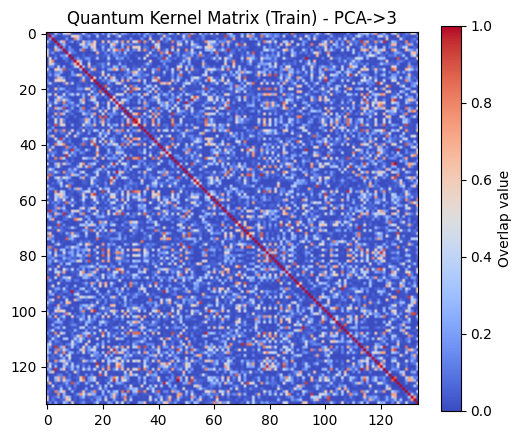

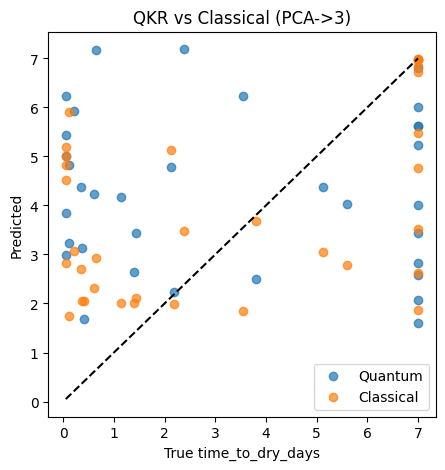

In [17]:
# === PCA + Quantum pipeline (QSVM and QKR) ===
import numpy as np
import pandas as pd
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ---- Config ----
DATA_PATH = "/content/drive/MyDrive/datasets/final_dryness_proxy_all.csv"  # change as needed
NUM_PCA_COMPONENTS = 3
RANDOM_STATE = 42

# ---- Load dataset ----
df = pd.read_csv(DATA_PATH)

# ---- Choose numeric columns (auto-detect) ----
num_df = df.select_dtypes(include=[np.number]).copy()
print("Numeric columns used for PCA:", num_df.columns.tolist())

# ---- Optional: drop the target if it's present in numeric set ----
target_col = "time_to_dry_days"
if target_col in num_df.columns:
    num_df = num_df.drop(columns=[target_col])

# ---- Fill missing numeric values (simple mean imputation) ----
num_df = num_df.fillna(num_df.mean())

# ---- Standardize before PCA ----
scaler_full = StandardScaler().fit(num_df.values)
X_num_std = scaler_full.transform(num_df.values)

# ---- PCA to 3 components ----
pca = PCA(n_components=NUM_PCA_COMPONENTS, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_num_std)
explained = pca.explained_variance_ratio_
print(f"Explained variance ratio (3 components): {explained}, total={explained.sum():.3f}")

# ---- Prepare targets ----
y_reg = df[target_col].values  # continuous target for regression
# binary label (optional) for QSVM classification (choose threshold)
threshold_days = 3.5
y_cls = (y_reg > threshold_days).astype(int)

# ---- Train/test split (use continuous target split; for classification you can use y_cls) ----
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X_pca, y_reg, test_size=0.2, random_state=RANDOM_STATE
)
# For classification: split matching indices
_, _, y_train_cls, y_test_cls = train_test_split(
    X_pca, y_cls, test_size=0.2, random_state=RANDOM_STATE
)

# ---- Quantum device and feature map (3 qubits) ----
n_qubits = NUM_PCA_COMPONENTS
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x):
    # Angle embedding of PCA components + simple nearest-neighbor CZ entanglement
    for i in range(n_qubits):
        qml.RY(np.pi * float(x[i]), wires=i)
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    return qml.probs(wires=range(n_qubits))

def quantum_kernel_matrix(X1, X2):
    n1, n2 = len(X1), len(X2)
    K = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            probs = kernel_circuit(X1[i], X2[j])
            K[i, j] = float(probs[0])  # overlap on |00..0>
    return K

# --- Compute kernel matrices (fast for small datasets) ---
print("Computing kernel matrices...")
K_train = quantum_kernel_matrix(X_train, X_train)
K_test = quantum_kernel_matrix(X_test, X_train)

# === 1) QSVM (classification on PCA components) ===
qsvm = SVC(kernel="precomputed")
qsvm.fit(K_train, y_train_cls)
y_pred_q_cls = qsvm.predict(K_test)
print("QSVM Accuracy (PCA->3):", accuracy_score(y_test_cls, y_pred_q_cls))
print("QSVM Confusion Matrix:\n", confusion_matrix(y_test_cls, y_pred_q_cls))

# === 2) QKR (regression using SVR on quantum kernel) ===
qkr = SVR(kernel="precomputed", C=1.0, epsilon=0.1)
qkr.fit(K_train, y_train_reg)
y_pred_q_reg = qkr.predict(K_test)
print("QKR MAE (PCA->3):", mean_absolute_error(y_test_reg, y_pred_q_reg))
print("QKR R2 (PCA->3):", r2_score(y_test_reg, y_pred_q_reg))

# === Classical baselines (using PCA components directly) ===
# Classical SVM classifier (RBF on PCA)
clf_rbf = SVC(kernel="rbf", gamma="scale")
clf_rbf.fit(X_train, y_train_cls)
y_pred_c_cls = clf_rbf.predict(X_test)
print("Classical RBF SVM Accuracy (PCA->3):", accuracy_score(y_test_cls, y_pred_c_cls))

# Classical SVR (RBF) on PCA
rsvr = SVR(kernel="rbf")
rsvr.fit(X_train, y_train_reg)
y_pred_c_reg = rsvr.predict(X_test)
print("Classical SVR MAE (PCA->3):", mean_absolute_error(y_test_reg, y_pred_c_reg))
print("Classical SVR R2 (PCA->3):", r2_score(y_test_reg, y_pred_c_reg))

# === Visualizations ===
plt.figure(figsize=(6,5))
plt.imshow(K_train, cmap="coolwarm")
plt.title("Quantum Kernel Matrix (Train) - PCA->3")
plt.colorbar(label="Overlap value")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(y_test_reg, y_pred_q_reg, label="Quantum", alpha=0.7)
plt.scatter(y_test_reg, y_pred_c_reg, label="Classical", alpha=0.7)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel("True time_to_dry_days")
plt.ylabel("Predicted")
plt.legend()
plt.title("QKR vs Classical (PCA->3)")
plt.show()

Explained variance ratio (3 components): [0.19565895 0.13420126 0.12673868], total=0.457

=== Classical SVR (RBF) ===
MAE: 2.1042510209269345
R² : 0.16863096273887235

=== Classical Linear Regression ===
MAE: 2.14743845872188
R² : 0.3536996709377702

=== Classical SVM (RBF) ===
Accuracy: 0.6764705882352942
Confusion Matrix:
 [[13  6]
 [ 5 10]]

=== Classical Logistic Regression ===
Accuracy: 0.7941176470588235
Confusion Matrix:
 [[16  3]
 [ 4 11]]


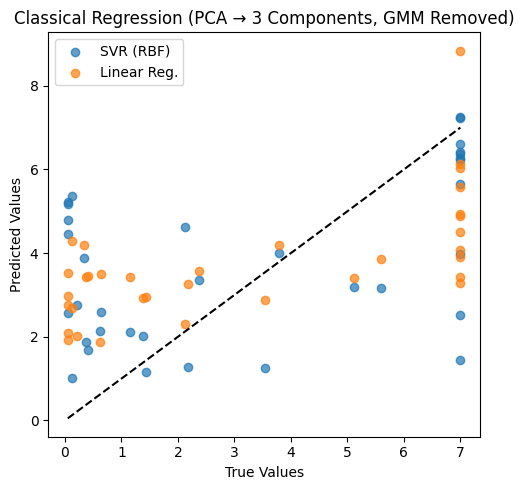

In [16]:
# === Classical PCA → ML (Regression + Classification, no GMM columns) ===
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_absolute_error,
    r2_score,
)
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("/content/drive/MyDrive/datasets/final_dryness_proxy_all.csv")

# --- Identify columns to exclude ---
exclude_cols = [
    "time_to_dry_days",  # target
    "gmm_label",
    "gmm_confidence",
]
available_cols = [c for c in df.columns if c not in exclude_cols]

# --- Select numeric columns only (excluding GMM/confidence/target) ---
num_df = df[available_cols].select_dtypes(include=[np.number]).copy()

# --- Handle missing values ---
num_df = num_df.fillna(num_df.mean())

# --- Standardize numeric data ---
scaler = StandardScaler().fit(num_df)
X_std = scaler.transform(num_df)

# --- PCA reduction to 3 components ---
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_std)
explained = pca.explained_variance_ratio_
print(f"Explained variance ratio (3 components): {explained}, total={explained.sum():.3f}")

# --- Target variable ---
target_col = "time_to_dry_days"
y_reg = df[target_col].values
y_cls = (y_reg > 3.5).astype(int)

# --- Split data ---
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X_pca, y_reg, test_size=0.2, random_state=42
)
_, _, y_train_cls, y_test_cls = train_test_split(
    X_pca, y_cls, test_size=0.2, random_state=42
)

# === Classical Regression ===
svr_rbf = SVR(kernel="rbf")
svr_rbf.fit(X_train, y_train_reg)
y_pred_svr = svr_rbf.predict(X_test)

linreg = LinearRegression()
linreg.fit(X_train, y_train_reg)
y_pred_lin = linreg.predict(X_test)

print("\n=== Classical SVR (RBF) ===")
print("MAE:", mean_absolute_error(y_test_reg, y_pred_svr))
print("R² :", r2_score(y_test_reg, y_pred_svr))

print("\n=== Classical Linear Regression ===")
print("MAE:", mean_absolute_error(y_test_reg, y_pred_lin))
print("R² :", r2_score(y_test_reg, y_pred_lin))

# === Classical Classification ===
svc_rbf = SVC(kernel="rbf", gamma="scale")
svc_rbf.fit(X_train, y_train_cls)
y_pred_svc = svc_rbf.predict(X_test)

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train_cls)
y_pred_log = logreg.predict(X_test)

print("\n=== Classical SVM (RBF) ===")
print("Accuracy:", accuracy_score(y_test_cls, y_pred_svc))
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, y_pred_svc))

print("\n=== Classical Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test_cls, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, y_pred_log))

# === Visualization ===
plt.figure(figsize=(5, 5))
plt.scatter(y_test_reg, y_pred_svr, label="SVR (RBF)", alpha=0.7)
plt.scatter(y_test_reg, y_pred_lin, label="Linear Reg.", alpha=0.7)
plt.plot(
    [y_test_reg.min(), y_test_reg.max()],
    [y_test_reg.min(), y_test_reg.max()],
    "k--",
)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.title("Classical Regression (PCA → 3 Components, GMM Removed)")
plt.tight_layout()
plt.show()

In [18]:
!pip install pennylane==0.38.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pennylane-lightning to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 61.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pennylane-lightning
    Found existing installation: pennylane_lightning 0.43.0
    Uninstalling pennylane_lightning-0.43.0:
      Successfully uninstalled pennylane_lightning-0.43.0
  Attempting uninstall: pennylane
    Found existing installation: pennylane 0.43.0
    Uninstalling pennylane-0.43.0:
      Successfully uninstalled pennylane-0.43.0
ERROR: pi

In [3]:
!pip uninstall -y pennylane autoray
!pip install "pennylane==0.36.0" "autoray==0.6.9"

Found existing installation: PennyLane 0.38.0
Uninstalling PennyLane-0.38.0:
  Successfully uninstalled PennyLane-0.38.0
Found existing installation: autoray 0.8.0
Uninstalling autoray-0.8.0:
  Successfully uninstalled autoray-0.8.0
INFO: pip is looking at multiple versions of pennylane-lightning to determine which version is compatible with other requirements. This could take a while.
  Using cached pennylane_lightning-0.43.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (11 kB)
  Using cached pennylane_lightning-0.42.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (11 kB)
  Using cached pennylane_lightning-0.41.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (12 kB)
  Using cached pennylane_lightning-0.41.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (28 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15

Loaded dataset with 168 rows
PCA components used: 6, variance explained = 0.918
Computing quantum kernel matrices...
Best QKR params: {'C': 1, 'epsilon': 0.01}

=== Final Comparison ===
Quantum Kernel Regression → MAE: 2.506, R²: 0.016
Classical SVR (RBF)       → MAE: 2.090, R²: 0.277


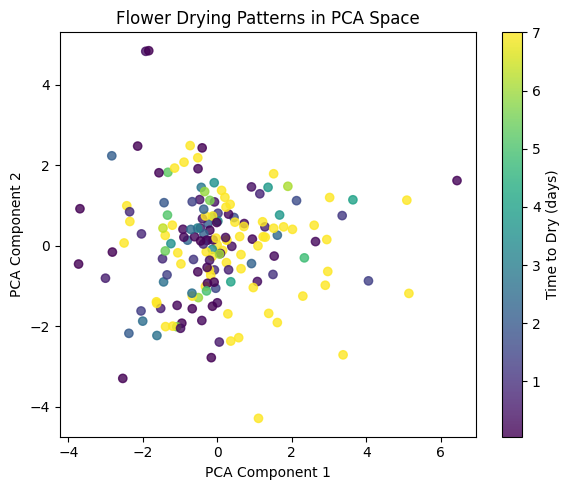

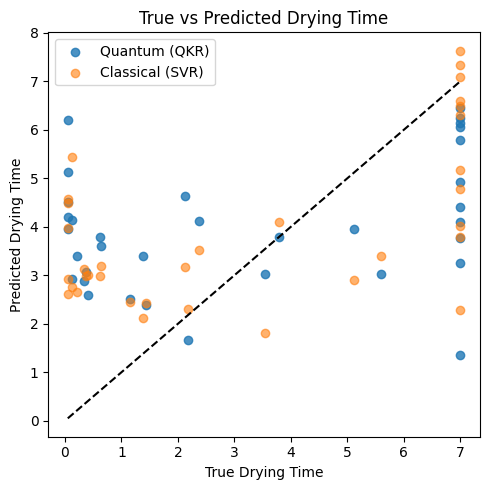

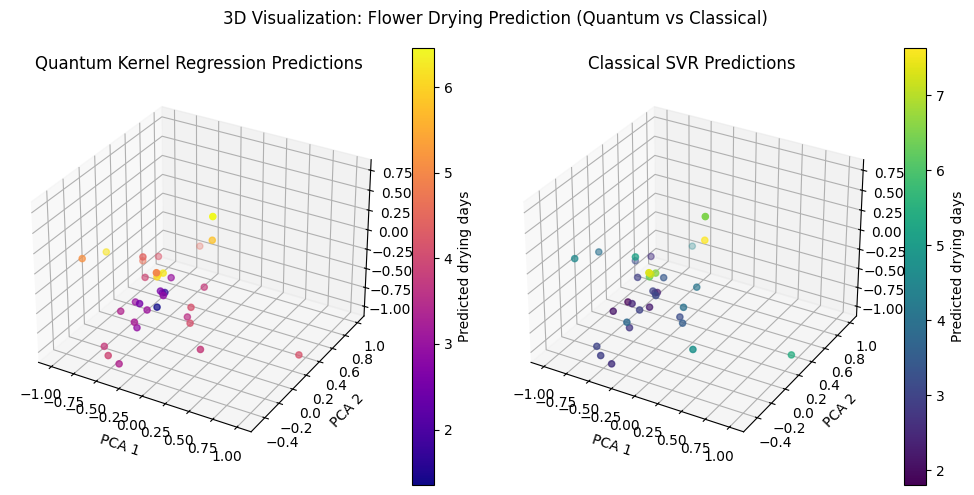

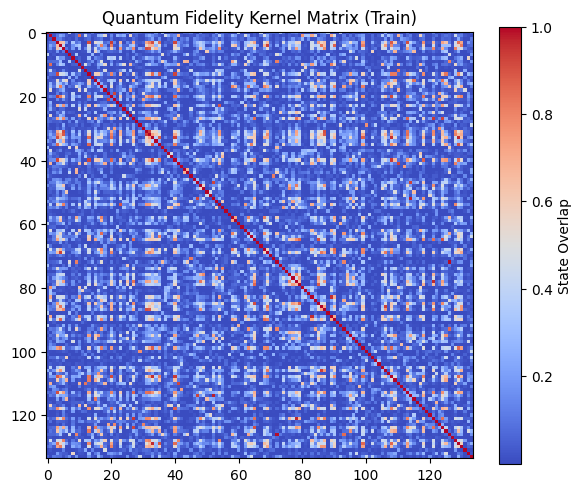

In [2]:
# ===================== FINAL QKR + CLASSICAL VISUALIZATION =====================
import importlib, sys, subprocess
try:
    import pennylane as qml
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pennylane==0.38.0"])
    import pennylane as qml

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from mpl_toolkits.mplot3d import Axes3D

# --- Configuration ---
DATA_PATH = "/content/drive/MyDrive/datasets/final_dryness_proxy_confident.csv"
PCA_VARIANCE_TARGET = 0.9
MAX_QUBITS = 6
RANDOM_STATE = 42

# --- Load dataset ---
df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset with {len(df)} rows")

# --- Feature prep ---
target_col = "time_to_dry_days"
exclude_cols = [target_col, "gmm_confidence", "gmm_label"]
num_df = df.select_dtypes(include=[np.number]).drop(columns=[c for c in exclude_cols if c in df.columns])
num_df = num_df.fillna(num_df.mean())

# --- PCA reduction ---
scaler = StandardScaler().fit(num_df)
X_std = scaler.transform(num_df)
pca = PCA(n_components=PCA_VARIANCE_TARGET, svd_solver="full", random_state=RANDOM_STATE)
X_pca_full = pca.fit_transform(X_std)

if X_pca_full.shape[1] > MAX_QUBITS:
    X_pca = PCA(n_components=MAX_QUBITS, random_state=RANDOM_STATE).fit_transform(X_std)
else:
    X_pca = X_pca_full
print(f"PCA components used: {X_pca.shape[1]}, variance explained = {pca.explained_variance_ratio_.sum():.3f}")

# --- Scale to [-1,1] for quantum ---
mm = MinMaxScaler(feature_range=(-1, 1)).fit(X_pca)
X_enc = mm.transform(X_pca)

y = df[target_col].values
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=RANDOM_STATE)

# --- Quantum kernel setup ---
n_qubits = X_train.shape[1]
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x, reps=2):
    for r in range(reps):
        for i in range(n_qubits):
            qml.RY(np.pi * float(x[i]), wires=i)
        for i in range(n_qubits - 1):
            qml.CZ(wires=[i, i+1])

@qml.qnode(dev)
def state_circuit(x):
    feature_map(x)
    return qml.state()

def kernel_fidelity(X1, X2):
    n1, n2 = len(X1), len(X2)
    K = np.zeros((n1, n2))
    states1 = [state_circuit(x) for x in X1]
    states2 = [state_circuit(x) for x in X2]
    for i in range(n1):
        for j in range(n2):
            ov = np.vdot(states1[i], states2[j])
            K[i, j] = np.abs(ov)**2
    return K

print("Computing quantum kernel matrices...")
K_train = kernel_fidelity(X_train, X_train)
K_test = kernel_fidelity(X_test, X_train)

# --- Quantum SVR (tuned) ---
params = {'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.05, 0.1, 0.5]}
svr_q = SVR(kernel="precomputed")
grid = GridSearchCV(svr_q, params, cv=3, scoring="neg_mean_absolute_error")
grid.fit(K_train, y_train)
qkr_best = grid.best_estimator_
print("Best QKR params:", grid.best_params_)

y_pred_qkr = qkr_best.predict(K_test)
mae_qkr = mean_absolute_error(y_test, y_pred_qkr)
r2_qkr = r2_score(y_test, y_pred_qkr)

# --- Classical SVR (RBF baseline) ---
svr_c = SVR(kernel="rbf", C=grid.best_params_['C'], epsilon=grid.best_params_['epsilon'])
svr_c.fit(X_train, y_train)
y_pred_c = svr_c.predict(X_test)
mae_c = mean_absolute_error(y_test, y_pred_c)
r2_c = r2_score(y_test, y_pred_c)

print("\n=== Final Comparison ===")
print(f"Quantum Kernel Regression → MAE: {mae_qkr:.3f}, R²: {r2_qkr:.3f}")
print(f"Classical SVR (RBF)       → MAE: {mae_c:.3f}, R²: {r2_c:.3f}")

# =================== VISUALIZATION SECTION ===================

# --- 1. PCA 2D projection colored by drying time ---
pca_viz = PCA(n_components=2).fit_transform(X_std)
plt.figure(figsize=(6,5))
plt.scatter(pca_viz[:,0], pca_viz[:,1], c=y, cmap='viridis', alpha=0.8)
plt.colorbar(label="Time to Dry (days)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Flower Drying Patterns in PCA Space")
plt.tight_layout()
plt.show()

# --- 2. QKR predictions (True vs Predicted) ---
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_qkr, alpha=0.8, label="Quantum (QKR)")
plt.scatter(y_test, y_pred_c, alpha=0.6, label="Classical (SVR)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--")
plt.xlabel("True Drying Time")
plt.ylabel("Predicted Drying Time")
plt.legend()
plt.title("True vs Predicted Drying Time")
plt.tight_layout()
plt.show()

# --- 3. 3D visualization (using top 3 PCA features) ---
if X_pca.shape[1] >= 3:
    fig = plt.figure(figsize=(10,5))

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    sc1 = ax1.scatter(X_test[:,0], X_test[:,1], X_test[:,2], c=y_pred_qkr, cmap='plasma')
    ax1.set_title("Quantum Kernel Regression Predictions")
    fig.colorbar(sc1, ax=ax1, label="Predicted drying days")

    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    sc2 = ax2.scatter(X_test[:,0], X_test[:,1], X_test[:,2], c=y_pred_c, cmap='viridis')
    ax2.set_title("Classical SVR Predictions")
    fig.colorbar(sc2, ax=ax2, label="Predicted drying days")

    for ax in [ax1, ax2]:
        ax.set_xlabel("PCA 1")
        ax.set_ylabel("PCA 2")
        ax.set_zlabel("PCA 3")

    plt.suptitle("3D Visualization: Flower Drying Prediction (Quantum vs Classical)")
    plt.tight_layout()
    plt.show()

# --- 4. Kernel heatmap (quantum structure) ---
plt.figure(figsize=(6,5))
plt.imshow(K_train, cmap="coolwarm")
plt.title("Quantum Fidelity Kernel Matrix (Train)")
plt.colorbar(label="State Overlap")
plt.tight_layout()
plt.show()

In [3]:
import joblib
import numpy as np

# Save classical model and scalers
joblib.dump(svr_c, "classical_svr_model.pkl")
joblib.dump(scaler, "scaler_full.pkl")
joblib.dump(pca, "pca_model.pkl")
joblib.dump(mm, "minmax_scaler.pkl")

# Save QKR kernel components
np.save("K_train.npy", K_train)
np.save("K_test.npy", K_test)
joblib.dump(qkr_best, "quantum_svr_model.pkl")

print("✅ All models and kernel data saved successfully.")

✅ All models and kernel data saved successfully.


In [4]:
import joblib
import numpy as np

def load_models():
    classical_svr = joblib.load("classical_svr_model.pkl")
    qkr_model = joblib.load("quantum_svr_model.pkl")
    scaler = joblib.load("scaler_full.pkl")
    pca = joblib.load("pca_model.pkl")
    mm = joblib.load("minmax_scaler.pkl")
    K_train = np.load("K_train.npy")

    return {
        "classical_svr": classical_svr,
        "qkr_model": qkr_model,
        "scaler": scaler,
        "pca": pca,
        "mm": mm,
        "K_train": K_train,
    }


In [5]:
!pip install github



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 56.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for aiohttp (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for aiohttp
Failed to build aiohttp
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (aiohttp)


In [19]:
!git config --global user.name "Mithrr"
!git config --global user.email "mitrajith01123@gmail.com"

In [20]:
%cd /content
!mkdir -p qml_flower_drying
%cd qml_flower_drying

/content
/content/qml_flower_drying


In [21]:
!cp /content/drive/MyDrive/models/classical_svr_model.pkl .
!cp /content/drive/MyDrive/models/quantum_svr_model.pkl .
!cp /content/drive/MyDrive/models/scaler_full.pkl .
!cp /content/drive/MyDrive/models/pca_model.pkl .
!cp /content/drive/MyDrive/models/minmax_scaler.pkl .
!cp /content/drive/MyDrive/models/K_train.npy .

In [22]:
!git init
!git add .
!git commit -m "Initial commit - Quantum + Classical ML Models"

Reinitialized existing Git repository in /content/qml_flower_drying/.git/
On branch main
nothing to commit, working tree clean


In [23]:
!git branch -M main
!git remote add origin https://github.com/Mithrr/QML_FLOWER_WITHERING

error: remote origin already exists.


In [24]:
from getpass import getpass
token = getpass("Enter your GitHub token: ")

!git remote set-url origin https://{token}@https://github.com/Mithrr/QML_FLOWER_WITHERING.git

Enter your GitHub token: ··········


In [25]:
!git push -u origin main

fatal: unable to access 'https://https://github.com/Mithrr/QML_FLOWER_WITHERING.git/': Could not resolve host: https


In [26]:
# 1. Remove the incorrect remote
!git remote remove origin

In [27]:
# 2. Add the correct one (only one 'https://')
!git remote add origin https://github.com/Mithrr/QML_FLOWER_WITHERING.git

In [28]:
from getpass import getpass
token = getpass("Enter your GitHub token: ")

!git remote set-url origin https://{token}@github.com/Mithrr/QML_FLOWER_WITHERING.git

Enter your GitHub token: ··········


In [29]:
!git push -u origin main

Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 127.31 KiB | 9.79 MiB/s, done.
Total 8 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), done.
To https://github.com/Mithrr/QML_FLOWER_WITHERING.git
 * [new branch]      main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


In [32]:
notebook_path = "/content/drive/MyDrive/ColabNotebooks/Untitled4.ipynb"

# Copy notebook to your repo folder
!cp "{notebook_path}" /content/qml_flower_drying/

# Commit and push to GitHub
%cd /content/qml_flower_drying
!git add QML_Flower_Withering.ipynb
!git commit -m "Add main Colab notebook with full QML workflow"
!git push -u origin main

cp: cannot stat '/content/drive/MyDrive/ColabNotebooks/QML_Flower_Withering.ipynb': No such file or directory
/content/qml_flower_drying
fatal: pathspec 'QML_Flower_Withering.ipynb' did not match any files
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Branch 'main' set up to track remote branch 'main' from 'origin'.
Everything up-to-date


In [ ]:
_